# [Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)
- Ship or iceberg, can you decide from space?

## Overview

### Description
漂流氷山は、カナダの東海岸の沖合などの地域での航行や活動に対する脅威を示しています。

現在、多くの機関や企業が空中偵察と陸上支援を使用して、環境条件を監視し、氷山のリスクを評価しています。しかし、特に荒天のある遠隔地では、これらの方法は実行できず、実行可能な監視オプションは衛星経由のみです。

世界中で事業を展開している国際的なエネルギー企業であるStatoilは、C-COREなどの企業と緊密に連携してきました。 C-COREは30年以上にわたって衛星データを使用しており、コンピュータビジョンベースの監視システムを構築しています。操業の安全性と効率性を維持するために、Statoilは、機械学習を使用して、脅威となる氷山をより正確に検出し、差別化する方法について、新たな視点を得ることに関心を持っています。

このコンテストでは、リモートで検出されたターゲットが船か氷山かを自動的に識別するアルゴリズムを構築する必要があります。行われた改善は、安全な労働条件を維持するためのコストを下げるのに役立ちます。

<div>
<img src="https://i.imgur.com/q7uAjTM.jpg" width="300" height="300" align="left"/>
</div>

### Evaluation
テストセットの各IDについて、画像に氷山（0から1の間の数）が含まれる確率を予測する必要があります。ファイルにはヘッダーが含まれ、次の形式である必要があります。

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from os.path import join as opj
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
df_train = pd.read_json('/Users/ikeda/Desktop/machine_learnings/Kaggle/Statoil:C-CORE_IcebergClassifierChallenge/statoil-iceberg-classifier-challenge/train.json')
df_test = pd.read_json('/Users/ikeda/Desktop/machine_learnings/Kaggle/Statoil:C-CORE_IcebergClassifierChallenge/statoil-iceberg-classifier-challenge/test.json')
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


### Data
- id
    - 画像のID
- band_1, band_2
    - 平坦化された画像データ。 各バンドのリストには75x75ピクセル値があるため、リストには5625個の要素があります。 これらの値は物理的な意味を持つため、画像ファイルでは通常の非負の整数ではないことに注意してください。これらは浮動小数点数であり、単位はdBです。 バンド1とバンド2は、特定の入射角で異なる偏光から生成されるレーダー後方散乱によって特徴付けられる信号です。 偏波は、HH（水平方向に送信/受信）およびHV（水平方向に送信し、垂直方向に受信）に対応しています。 衛星画像の背景については、こちらをご覧ください。
- inc_angle
    - 画像が取得された入射角。 このフィールドには「na」とマークされた欠落データがあり、「na」の入射角を持つ画像はすべて漏れを防ぐためにトレーニングデータに含まれていることに注意してください。
- is_iceberg
    - ターゲット変数。氷山の場合は1に設定され、船の場合は0に設定されます。 このフィールドはtrain.jsonにのみ存在します。

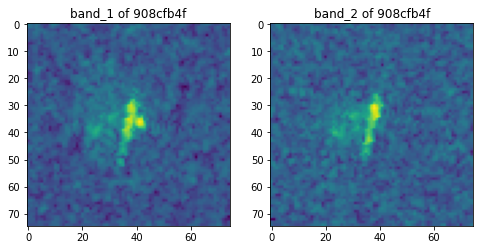

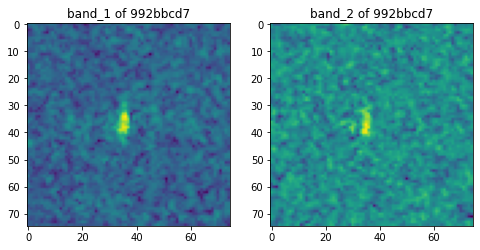

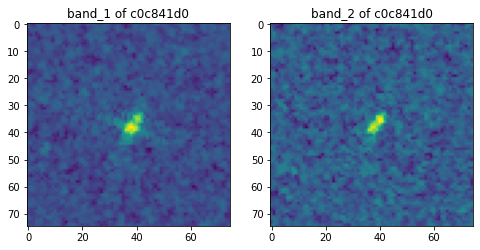

In [3]:
# randomに３つ画像表示
for i in np.random.randint(0, len(df_train), 3):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.array(df_train['band_1'][i]).reshape(75, -1))
    ax.set_title('band_1 of {}'.format(df_train['id'][i]))
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.array(df_train['band_2'][i]).reshape(75, -1))
    ax.set_title('band_2 of {}'.format(df_train['id'][i]))
    plt.show()

### [Keras Model for Beginners (0.210 on LB)+EDA+R&D](https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d)

In [4]:
train = deepcopy(df_train)
test = deepcopy(df_test)

#### Intro about the Data.

Sentinet -1 satは地球上約680 Kmにあります。 特定の入射角で信号のパルスを送信し、それを再記録します。 基本的に、これらの反射信号は後方散乱と呼ばれます。 私たちが与えられたデータは、後方散乱係数であり、これは、以下によって与えられる後方散乱係数の従来の形式です。

$
σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)]
$
1. ip =特定のピクセルの入射角
2. ic =画像の中心の入射角です
3. K =一定。

σoσoはデータで直接指定されています。

##### Now coming to the features of  σo

基本的に、σoは信号が散乱する表面によって異なります。たとえば、特定の入射角では、次のように変化します。

WATER........... SETTLEMENTS........ AGRICULTURE........... BARREN........

1.HH: -27.001 ................ 2.70252 ................. -12.7952 ................ -17.25790909

2.HV: -28.035 ................ -20.2665 .................. -21.4471 ................. -20.019

ご覧のとおり、HHコンポーネントはさまざまですが、HVはそうではありません。船からの散乱のデータはありませんが、金属のオブジェクトなので、氷のオブジェクトとは異なります。

#### WTF is HH HV?
わかりましたので、このセンチメンタルSettaliteはRISTSAT（インドのリモートセンシング土）と同等で、pingをH偏波でのみ送信し、V偏波では送信しません。 これらのH-pingは散乱し、オブジェクトは偏光を変化させ、HとVの混合として戻ります。SentinelにはHトランスミッタしかないため、戻り信号はHHとHVのみの形式になります。 なぜVVが与えられないのか質問しないでください（SentinelにはV-ping送信機がないため）。

機能については、このデモコードの目的で、2つすべてのバンドを抽出し、それらの平均を3番目のチャネルとして取得して、3チャネルRGBに相当するものを作成します。

In [5]:
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [7]:
plotmy3d(X_band_1[12,:,:], 'iceberg')

それは私たちが持っている格好良い氷山です。 ここに示すように、レーダーデータでは、氷山の形状は山のようになります。 これは実際の画像ではなくレーダーからの散乱なので、形状にはこのようなピークと歪みが生じます。 船の形は点のようになり、細長い点のようになるかもしれません。 ここから構造の違いが発生し、CNNを使用してそれらの違いを活用できます。 レーダーからの後方散乱を使用して合成画像を作成できると便利です。

In [8]:
plotmy3d(X_band_1[14,:,:], 'Ship')

それは船であり、細長い点のように見えます。船の形を視覚化するための画像の解像度はあまりありません。ただし、CNNがお手伝いします。次のような船の氷山分類に関する論文はほとんどありません。
[http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf](http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf)
しかし、彼らのデータははるかに良い解像度を持っているので、彼らが使用したCNNがここでは適切だとは思わない。
Kerasを使用してCNNの構築に戻ります。他のものよりもはるかに優れたフレームワーク。きっとお楽しみいただけます。

In [9]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


In [10]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [11]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [12]:
#Without denoising, core features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [13]:
gmodel.load_weights(file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - 2s 4ms/step
Test loss: 0.26302040351596556
Test accuracy: 0.8902742862701416


In [14]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

In [15]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

数回試してみて、Test lossが低かったものを実際に提出してみた。
3000強の2000番目ぐらい